In [1]:
!curl -o /tmp/stackex.csv https://raw.githubusercontent.com/Raphtory/Data/main/stackexchange.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5613k  100 5613k    0     0  17.0M      0 --:--:-- --:--:-- --:--:-- 17.0M


In [2]:
import pandas as pd
from pyraphtory.context import PyRaphtory
from pyraphtory.input import ImmutableString
from pyraphtory.input import GraphBuilder
from pyraphtory.spouts import FileSpout
from pyraphtory.sources import CSVEdgeListSource
from pyraphtory.sources import Source
from pyraphtory.graph import Row
import csv
structure_file = "/tmp/stackex.csv"

ctx = PyRaphtory.local()

In [3]:
graph = ctx.new_graph()
with open(structure_file, 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for row in datareader:
      graph.add_edge(row[2],int(row[0]),int(row[1]),time_format="yyyy-MM-dd HH:mm:ss")


In [4]:
windows = ["1 day", "1 week", "1 month", "1 year"]
graph = graph.set_output_as_datetime()
df_nodes = graph \
    .walk("1 year") \
    .date_window(windows) \
    .execute(ctx.algorithms.generic.NodeEdgeCount)\
    .to_df(["nodes", "edges_dir", "edges_undir", "temporal_edges"])

In [5]:
df_nodes.tail(20)

,timestamp,window,nodes,edges_dir,edges_undir,temporal_edges
12,2012-09-29 07:36:52.000,1 day,121,82,82,82
13,2012-09-29 07:36:52.000,1 week,478,522,522,522
14,2012-09-29 07:36:52.000,1 month,1287,2334,2334,2334
15,2012-09-29 07:36:52.000,1 year,6320,28376,28376,28376
16,2013-09-29 07:36:52.000,1 day,88,56,56,56
17,2013-09-29 07:36:52.000,1 week,485,474,474,474
18,2013-09-29 07:36:52.000,1 month,1301,1927,1927,1927
19,2013-09-29 07:36:52.000,1 year,7244,28364,28364,28364
20,2014-09-29 07:36:52.000,1 day,72,44,44,44
21,2014-09-29 07:36:52.000,1 week,451,404,404,404


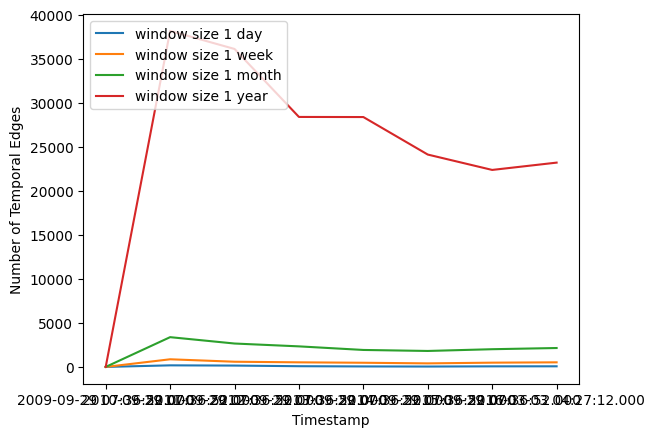

In [6]:
import matplotlib.pyplot as plt
import datetime as dt

fig, ax = plt.subplots()
ax.set_xlabel("Timestamp")
ax.set_ylabel("Number of Temporal Edges")

for window in windows:
    df_sub = df_nodes[df_nodes["window"] == window]
    dates = df_sub["timestamp"]
    ax.plot(dates, df_sub.temporal_edges, label = "window size "+str(window))

ax.legend(loc= "upper left")
plt.show()

In [7]:
from pyraphtory.scala.implicits.numeric import Long

df_community = graph \
    .execute(ctx.algorithms.generic.community.LPA[Long]())\
    .to_df(["name", "community"])

In [9]:
df_clustering = graph \
    .walk("1 day") \
    .date_window(windows) \
    .execute(ctx.algorithms.generic.motif.GlobalClusteringCoefficient)\
    .to_df(["avgCluster", "globalCluster"])

In [10]:
df_clustering.tail()

,timestamp,window,avgCluster,globalCluster
9387,2016-03-02 06:36:52.000,1 year,0.057036,0.0
9388,2016-03-03 04:27:12.000,1 day,0.000000,0.0
9389,2016-03-03 04:27:12.000,1 week,0.011324,0.0
9390,2016-03-03 04:27:12.000,1 month,0.025300,0.0
9391,2016-03-03 04:27:12.000,1 year,0.057196,0.0


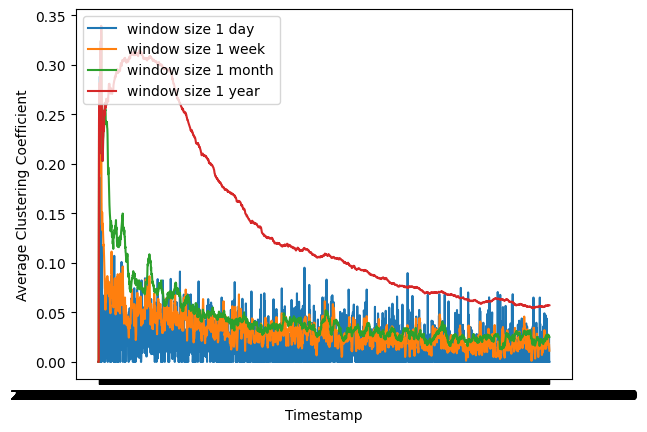

In [12]:
import matplotlib.pyplot as plt
import datetime as dt

fig, ax = plt.subplots()
ax.set_xlabel("Timestamp")
ax.set_ylabel("Average Clustering Coefficient")

for window in windows:
    df_sub = df_clustering[df_clustering["window"] == window]
    dates = df_sub["timestamp"]
    ax.plot(dates, df_sub.avgCluster, label = "window size "+str(window))

ax.legend(loc= "upper left")
plt.show()